In [1]:
%matplotlib inline

In [3]:
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from IPython.display import display
import geopandas as gpd
from shapely.geometry import Point
import shapely
shapely.speedups.enable()
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

In [4]:
def canonize_name(n):
    return n.strip().lower().replace('  ',' ').replace(' ', '_')

In [5]:
states = ['chandigarh', 
          'delhi', 
          'haryana',
          'himachal_pradesh',
          'punjab',
          'rajasthan',
          'uttar_pradesh',
          'uttarakhand']

In [6]:
stations = pd.concat([pd.read_csv("./stn_data.csv"), pd.read_csv("./delhi_stn_data.csv")])

In [7]:
stations.head()

,Latitude,Longitude,address,location,stn_code
0,30.705433,76.800596,"Modern Foods, Industrial Area, Chandigarh, Cha...","{'lat': 30.705433, 'lng': 76.800596}",106
1,30.739834,76.782702,"Sector-17 C, Chandigarh, Chandigarh, Chandigar...","{'lat': 30.7398339, 'lng': 76.782702}",263
2,30.768049,76.782702,"Punjab Engineering College, Sector-12, Chandig...","{'lat': 30.7680494, 'lng': 76.782702}",264
3,30.747768,76.733700,"IMTECH Sector 39, Chandigarh, Chandigarh, Chan...","{'lat': 30.747768, 'lng': 76.7337}",463
4,30.755282,76.823082,"Kaimbwala Village, Chandigarh, Chandigarh, Cha...","{'lat': 30.7552818, 'lng': 76.8230815}",464


# exposure

In [8]:
all_df = pd.DataFrame()
for s in states:
    for y in range(2014, 2016):
        fname = "./exposure_data/cpcb_dly_aq_{state}-{year}.csv".format(state=s, year=y)
        if os.path.isfile(fname):
            print(s, y)
            all_df = pd.concat([all_df,
                                pd.read_csv(fname)])
        else:
            print("Not found:", fname)

chandigarh 2014
chandigarh 2015
delhi 2014
delhi 2015
haryana 2014
haryana 2015
himachal_pradesh 2014
himachal_pradesh 2015
punjab 2014
punjab 2015
rajasthan 2014
rajasthan 2015
uttar_pradesh 2014
uttar_pradesh 2015
Not found: ./exposure_data/cpcb_dly_aq_uttarakhand-2014.csv
uttarakhand 2015


In [9]:
a = set(all_df['Stn Code'].unique())

In [10]:
b = set(stations.stn_code.unique())

In [11]:
all_df[all_df['Stn Code'].isin(a - b)].head(1)

,Stn Code,Sampling Date,State,City/Town/Village/Area,Location of Monitoring Station,Agency,Type of Location,SO2,NO2,RSPM/PM10,PM 2.5


In [12]:
all_df = pd.merge(all_df, stations, left_on='Stn Code', right_on='stn_code')

In [13]:
all_df.columns

Index(['Stn Code', 'Sampling Date', 'State', 'City/Town/Village/Area',
       'Location of Monitoring Station', 'Agency', 'Type of Location', 'SO2',
       'NO2', 'RSPM/PM10', 'PM 2.5', 'Latitude', 'Longitude', 'address',
       'location', 'stn_code'],
      dtype='object')

In [14]:
all_df['Sampling Date'] = pd.to_datetime(all_df['Sampling Date'])

In [15]:
all_df.head()

,Stn Code,Sampling Date,State,City/Town/Village/Area,Location of Monitoring Station,Agency,Type of Location,SO2,NO2,RSPM/PM10,PM 2.5,Latitude,Longitude,address,location,stn_code
0,106,2014-01-01,Chandigarh,Chandigarh,"Modern Foods, Industrial Area, Chandigarh",Chandigarh Pollution Control Committee,Industrial Area,2.0,16.0,247.0,NaN,30.705433,76.800596,"Modern Foods, Industrial Area, Chandigarh, Cha...","{'lat': 30.705433, 'lng': 76.800596}",106
1,106,2014-01-03,Chandigarh,Chandigarh,"Modern Foods, Industrial Area, Chandigarh",Chandigarh Pollution Control Committee,Industrial Area,2.0,44.0,247.0,NaN,30.705433,76.800596,"Modern Foods, Industrial Area, Chandigarh, Cha...","{'lat': 30.705433, 'lng': 76.800596}",106
2,106,2014-01-06,Chandigarh,Chandigarh,"Modern Foods, Industrial Area, Chandigarh",Chandigarh Pollution Control Committee,Industrial Area,2.0,50.0,263.0,NaN,30.705433,76.800596,"Modern Foods, Industrial Area, Chandigarh, Cha...","{'lat': 30.705433, 'lng': 76.800596}",106
3,106,2014-01-08,Chandigarh,Chandigarh,"Modern Foods, Industrial Area, Chandigarh",Chandigarh Pollution Control Committee,Industrial Area,2.0,39.0,306.0,NaN,30.705433,76.800596,"Modern Foods, Industrial Area, Chandigarh, Cha...","{'lat': 30.705433, 'lng': 76.800596}",106
4,106,2014-01-10,Chandigarh,Chandigarh,"Modern Foods, Industrial Area, Chandigarh",Chandigarh Pollution Control Committee,Industrial Area,2.0,43.0,89.0,NaN,30.705433,76.800596,"Modern Foods, Industrial Area, Chandigarh, Cha...","{'lat': 30.705433, 'lng': 76.800596}",106


In [16]:
def agg_set(x):
    return len(set(x))

final_df = all_df.groupby(['Stn Code', all_df['Sampling Date'].dt.year]).agg({
    'RSPM/PM10': 'mean',
    'Latitude': 'max',
    'Longitude': 'max',
    'State': 'max',
    'Location of Monitoring Station': 'max'
}).reset_index()

In [17]:
final_df.rename(columns={
    'Stn Code': 'stn_code',
    'RSPM/PM10': 'pm10',
    'Sampling Date': 'year',
    'Location of Monitoring Station': 'address'
}, inplace=True)

In [18]:
final_df.head()

,stn_code,year,pm10,Latitude,Longitude,State,address
0,1,2014,151.333333,27.175015,78.042155,Uttar Pradesh,"Taj Mahal, Agra"
1,1,2015,165.295139,27.175015,78.042155,Uttar Pradesh,"Taj Mahal, Agra"
2,6,2014,128.070000,24.198823,82.767296,Uttar Pradesh,"Anpara Colony, Sonabhadra, Anpara"
3,6,2015,132.978022,24.198823,82.767296,Uttar Pradesh,"Anpara Colony, Sonabhadra, Anpara"
4,7,2014,133.079208,24.182727,82.789890,Uttar Pradesh,"Renusagar Colony, Sonabhadra, Anpara"


In [19]:
india = gpd.read_file("./map/IND_adm2.shp")

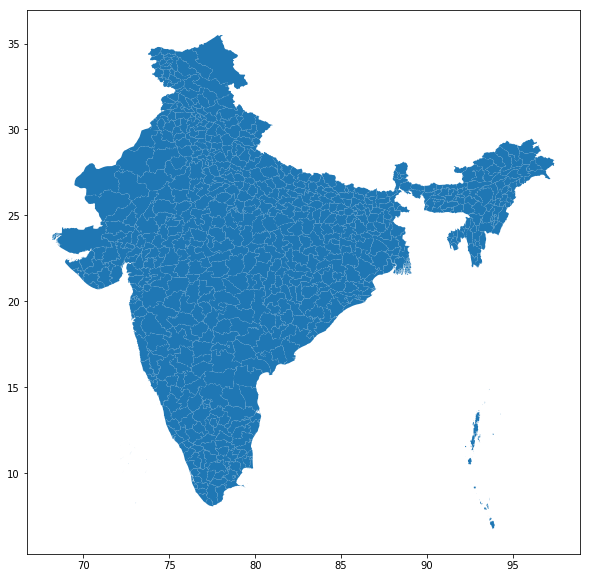

In [20]:
india.plot()

In [21]:
india.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,HASC_2,CCN_2,CCA_2,TYPE_2,ENGTYPE_2,NL_NAME_2,VARNAME_2,geometry
0,105,IND,India,1,Andaman and Nicobar,1,Nicobar Islands,IN.AN.NI,0,,District,District,,,(POLYGON ((92.78778076171886 9.244166374206543...
1,105,IND,India,1,Andaman and Nicobar,2,North and Middle Andaman,IN.AN.NM,0,,District,District,,,(POLYGON ((93.64840698242182 14.93486976623529...
2,105,IND,India,1,Andaman and Nicobar,3,South Andaman,IN.AN.SA,0,,District,District,,,(POLYGON ((93.83969879150402 12.32081985473638...
3,105,IND,India,2,Andhra Pradesh,4,Anantapur,IN.AD.AN,0,,District,District,,"Anantpur, Ananthapur","POLYGON ((77.69000244140619 15.17628002166754,..."
4,105,IND,India,2,Andhra Pradesh,5,Chittoor,IN.AD.CH,0,,District,District,,Chitoor|Chittor,"POLYGON ((78.47611236572271 13.93680191040033,..."


In [22]:
geometry = [Point(xy) for xy in zip(final_df.Longitude, final_df.Latitude)]

In [23]:
crs = {'init': 'epsg:4326'}
final_gdf = gpd.GeoDataFrame(final_df, crs=crs, geometry=geometry)

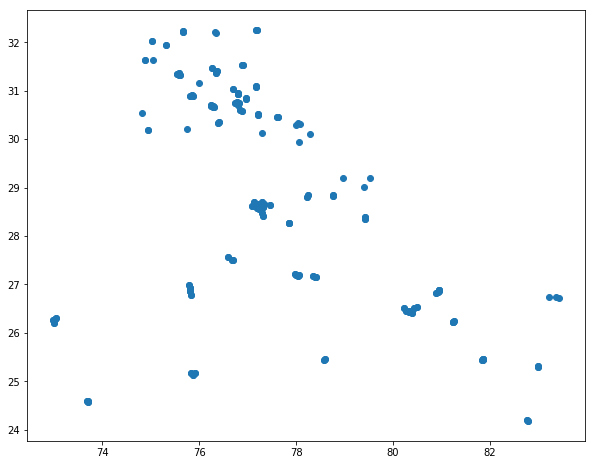

In [24]:
final_gdf.plot()

In [25]:
exposure_df = gpd.sjoin(final_gdf, india, how='inner', op='intersects')

In [26]:
exposure_df.head()

,stn_code,year,pm10,Latitude,Longitude,State,address,geometry,index_right,ID_0,...,NAME_1,ID_2,NAME_2,HASC_2,CCN_2,CCA_2,TYPE_2,ENGTYPE_2,NL_NAME_2,VARNAME_2
0,1,2014,151.333333,27.175015,78.042155,Uttar Pradesh,"Taj Mahal, Agra",POINT (78.0421552 27.1750151),559,105,...,Uttar Pradesh,559,Agra,IN.UP.AG,0,,District,District,,
1,1,2015,165.295139,27.175015,78.042155,Uttar Pradesh,"Taj Mahal, Agra",POINT (78.0421552 27.1750151),559,105,...,Uttar Pradesh,559,Agra,IN.UP.AG,0,,District,District,,
89,323,2014,161.157895,27.207770,77.977434,Uttar Pradesh,"Regional Office, Bodla, Agra",POINT (77.9774341 27.2077695),559,105,...,Uttar Pradesh,559,Agra,IN.UP.AG,0,,District,District,,
90,323,2015,166.753086,27.207770,77.977434,Uttar Pradesh,"Regional Office, Bodla, Agra",POINT (77.9774341 27.2077695),559,105,...,Uttar Pradesh,559,Agra,IN.UP.AG,0,,District,District,,
159,417,2014,169.226277,27.203916,78.001391,Uttar Pradesh,"Rambagh, Agra",POINT (78.0013908 27.203916),559,105,...,Uttar Pradesh,559,Agra,IN.UP.AG,0,,District,District,,


In [27]:
exposure_df.groupby(['stn_code', 'address', 'State','NAME_2', 'NAME_1']).year.count().reset_index().head()

,stn_code,address,State,NAME_2,NAME_1,year
0,1,"Taj Mahal, Agra",Uttar Pradesh,Agra,Uttar Pradesh,2
1,6,"Anpara Colony, Sonabhadra, Anpara",Uttar Pradesh,Sonbhadra,Uttar Pradesh,2
2,7,"Renusagar Colony, Sonabhadra, Anpara",Uttar Pradesh,Sonbhadra,Uttar Pradesh,2
3,17,"Regional Office, RJPB, Anantpura, Kota",Rajasthan,Kota,Rajasthan,2
4,34,"Tekka Bench Ridge, Simla",Himachal Pradesh,Shimla,Himachal Pradesh,2


In [28]:
exposure_df.columns

Index(['stn_code', 'year', 'pm10', 'Latitude', 'Longitude', 'State', 'address',
       'geometry', 'index_right', 'ID_0', 'ISO', 'NAME_0', 'ID_1', 'NAME_1',
       'ID_2', 'NAME_2', 'HASC_2', 'CCN_2', 'CCA_2', 'TYPE_2', 'ENGTYPE_2',
       'NL_NAME_2', 'VARNAME_2'],
      dtype='object')

In [29]:
selected_columns = [
    'stn_code', 'year', 'pm10', 'Latitude', 'Longitude', 'State', 'address',
    'ID_1', 'NAME_1', 'ID_2', 'NAME_2', 'VARNAME_2'
]
exposure_df[selected_columns].to_csv("exposure1.csv", index=False)

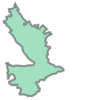

In [30]:
india[india.ID_2==467].geometry.tolist()[0]

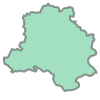

In [31]:
india[india.ID_1==25].geometry.tolist()[0]

In [32]:
india[india.ID_2==467]

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,HASC_2,CCN_2,CCA_2,TYPE_2,ENGTYPE_2,NL_NAME_2,VARNAME_2,geometry
index_right,,,,,,,,,,,,,,,
467,105,IND,India,28,Punjab,467,Rupnagar,IN.PB.RP,0,,District,District,,"Ropar, Roop Nagar, Rupar","POLYGON ((76.38162994384766 31.41061973571789,..."


# prediction data

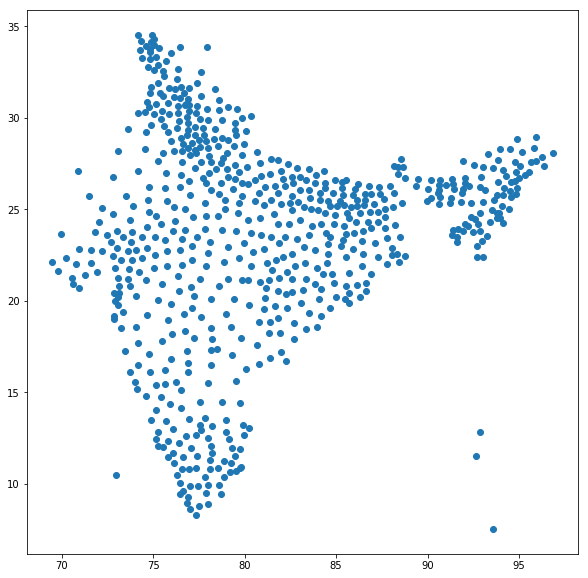

In [33]:
india['centroid_column'] = india.centroid
india.set_geometry('centroid_column').plot()

In [34]:
records = []
for i, r in india.iterrows():
    records.append({
        'ID_1': r.ID_1,
        'NAME_1': canonize_name(r.NAME_1),
        'ID_2': r.ID_2,
        'NAME_2': canonize_name(r.NAME_2),
        'Latitude': r.centroid_column.y,
        'Longitude': r.centroid_column.x,
    })

In [35]:
df_pred = pd.DataFrame(records)
df_pred.to_csv("predict1_jan28.csv", index=False)

# covariate data

In [36]:
df_census = pd.DataFrame()
selected_columns = {'Name' : 'District',
                    'Total Population Person': 'total_population',
                    'Total Population Male': 'total_males',
                    'Total Population Female': 'total_females',
                   }
for f in os.listdir("./covariate_data/"):
    if not f.startswith('PCA'):
        continue
    df = pd.read_excel("./covariate_data/"+f)
    state_name = df[df.Level=='STATE'].Name.unique().tolist()[0].lower()
    df = df[((df.Level=='DISTRICT') & (df.TRU=='Total'))][list(selected_columns.keys())].rename(columns = selected_columns)
    df['state'] = canonize_name(state_name)
    df['District'] = df['District'].apply(canonize_name)
    df_census = pd.concat([df_census, df])


In [37]:
df_census.head()

,District,total_population,total_males,total_females,state
3,sheopur,687861,361784,326077,madhya_pradesh
6,morena,1965970,1068417,897553,madhya_pradesh
9,bhind,1703005,926843,776162,madhya_pradesh
12,gwalior,2032036,1090327,941709,madhya_pradesh
15,datia,786754,420157,366597,madhya_pradesh


In [38]:
df_pred_census = pd.merge(df_pred, df_census, left_on=['NAME_1', 'NAME_2'], right_on=['state', 'District'])

In [39]:
df_pred_census.head()

,ID_1,ID_2,Latitude,Longitude,NAME_1,NAME_2,District,total_population,total_males,total_females,state
0,2,4,14.475092,77.570846,andhra_pradesh,anantapur,anantapur,4081148,2064495,2016653,andhra_pradesh
1,2,5,13.456597,79.003938,andhra_pradesh,chittoor,chittoor,4174064,2090204,2083860,andhra_pradesh
2,2,6,17.183853,82.001021,andhra_pradesh,east_godavari,east_godavari,5154296,2569688,2584608,andhra_pradesh
3,2,7,16.291439,80.081278,andhra_pradesh,guntur,guntur,4887813,2440521,2447292,andhra_pradesh
4,2,8,16.550411,80.792897,andhra_pradesh,krishna,krishna,4517398,2267375,2250023,andhra_pradesh


In [40]:
df_pred[(~df_pred.NAME_2.isin(set(df_pred_census.NAME_2.unique()))) & (df_pred.NAME_1=='uttar_pradesh')]

,ID_1,ID_2,Latitude,Longitude,NAME_1,NAME_2
563,34,563,26.286784,81.630814,uttar_pradesh,amethi
564,34,564,28.843397,78.349147,uttar_pradesh,amroha
572,34,572,26.916742,81.371661,uttar_pradesh,barabanki
593,34,593,28.717799,77.870153,uttar_pradesh,hapur
595,34,595,27.576148,78.144032,uttar_pradesh,hathras
602,34,602,27.782238,78.836772,uttar_pradesh,kasganj
605,34,605,28.127597,80.656539,uttar_pradesh,lakhimpur_kheri
608,34,608,27.188149,83.500783,uttar_pradesh,maharajganj
622,34,622,28.454091,78.527646,uttar_pradesh,sambhal
624,34,624,25.350985,82.455649,uttar_pradesh,sant_ravi_das_nagar


In [41]:
df_census[df_census.state=='uttar_pradesh'].District.unique()

array(['saharanpur', 'muzaffarnagar', 'bijnor', 'moradabad', 'rampur',
       'jyotiba_phule_nagar', 'meerut', 'baghpat', 'ghaziabad',
       'gautam_buddha_nagar', 'bulandshahr', 'aligarh', 'mahamaya_nagar',
       'mathura', 'agra', 'firozabad', 'mainpuri', 'budaun', 'bareilly',
       'pilibhit', 'shahjahanpur', 'kheri', 'sitapur', 'hardoi', 'unnao',
       'lucknow', 'rae_bareli', 'farrukhabad', 'kannauj', 'etawah',
       'auraiya', 'kanpur_dehat', 'kanpur_nagar', 'jalaun', 'jhansi',
       'lalitpur', 'hamirpur', 'mahoba', 'banda', 'chitrakoot', 'fatehpur',
       'pratapgarh', 'kaushambi', 'allahabad', 'bara_banki', 'faizabad',
       'ambedkar_nagar', 'sultanpur', 'bahraich', 'shrawasti', 'balrampur',
       'gonda', 'siddharthnagar', 'basti', 'sant_kabir_nagar',
       'mahrajganj', 'gorakhpur', 'kushinagar', 'deoria', 'azamgarh',
       'mau', 'ballia', 'jaunpur', 'ghazipur', 'chandauli', 'varanasi',
       'sant_ravidas_nagar_(bhadohi)', 'mirzapur', 'sonbhadra', 'etah',
    

In [42]:
# df_pred[df_pred.NAME_1=='uttar_pradesh'].NAME_2.unique()

In [43]:
df_pred_census.head()

,ID_1,ID_2,Latitude,Longitude,NAME_1,NAME_2,District,total_population,total_males,total_females,state
0,2,4,14.475092,77.570846,andhra_pradesh,anantapur,anantapur,4081148,2064495,2016653,andhra_pradesh
1,2,5,13.456597,79.003938,andhra_pradesh,chittoor,chittoor,4174064,2090204,2083860,andhra_pradesh
2,2,6,17.183853,82.001021,andhra_pradesh,east_godavari,east_godavari,5154296,2569688,2584608,andhra_pradesh
3,2,7,16.291439,80.081278,andhra_pradesh,guntur,guntur,4887813,2440521,2447292,andhra_pradesh
4,2,8,16.550411,80.792897,andhra_pradesh,krishna,krishna,4517398,2267375,2250023,andhra_pradesh


# outcome

In [44]:
selected_columns = {
    'name': 'District',
    'total_male': 'total_male_deaths',
    'total_female': 'total_female_deaths',
    'total_total': 'total_deaths'
}
df_outcome = pd.DataFrame()
for f in os.listdir("./outcome_extracted/2015/"):
    df = pd.read_excel("./outcome_extracted/2015/"+f)
    df_outcome = pd.concat([df_outcome, df[(df.is_state==False)&(df.cohort=='deaths')][list(selected_columns.keys())].rename(columns=selected_columns)])
df_outcome.District = df_outcome.District.apply(canonize_name)

In [46]:
df_pred_census_outcome = pd.merge(df_pred_census, df_outcome, on='District')

In [47]:
len(df_census), len(df_outcome), len(df_pred), len(df_pred_census_outcome)

(640, 660, 667, 493)

In [50]:
odist = set(df_outcome.District.unique())
cdist = set(df_pred_census_outcome.District.unique())

In [51]:
cdist-odist

set()

In [52]:
df_pred_census_outcome.to_csv("final_data_e_c_o.csv")